#### Declarations and definitions

In [1]:
import numpy
import gensim
import math
from gensim.models.word2vec import Word2Vec
from keras.preprocessing import sequence
from gensim.models.doc2vec import TaggedDocument
from collections import namedtuple
from keras.models import load_model
import statistics
import random
import glob
import os
import datetime
from pathlib import Path
import matplotlib.pyplot as plt

homePath = str(Path.home()) + "/MLClassificationData"
LabeledSentence = gensim.models.doc2vec.TaggedDocument
# Dimension of word vectors
n_dim = 100
# Count of categories (labels).
n_cats = 0
# Count of words, which aren't found in w2v vocabulary.
nf_words = 0
# This id is included into the names of models, created by this notebook.
modelId = 4
# Path to tokenized corpus for training
trainRoot = homePath + '/train/rtanews/target'
# Path to tokenized corpus for testing
testRoot = homePath + '/test/rtanews/target'
# Path for saving best results, achieved in the time of training
best_models_path = homePath + '/models/rtanews/tempModels/'
# Path for full model info
modelInfoPath = homePath + '/models/rtanews/modelinfo/'
# Part of the training corpus, used for runtime validation
valPart = 0.15
batch_size = 128
numpy.random.seed(1)
cnt = 0
nCats = 0
categories = dict()

LabeledDocument = namedtuple('LabeledDocument', 'words labels qLabs name')

def getCategories(path):
    cats = dict()
    nCats = 0
    os.chdir(path)
    for f in glob.glob("*"):
        if os.path.isdir(f):
            cats[f] = nCats
            nCats += 1
    return cats

def prepareDocsData(path, cats):
    files = dict()
    fInCats = [0] * len(cats)
    nFiles = 0
    actFiles = 0
    curCategory = 0
    docs = []
    os.chdir(path)
    rootDir = os.getcwd()
    for f in glob.glob("*"):
        curCategory = cats[f]
        catPath = path + "/" + f
        os.chdir(catPath)
        for fc in glob.glob("*"):
            actFiles += 1
            if fc not in files:
                nFiles += 1
                fPath = catPath + "/" + fc
                docCont = ''
                with open(fc, 'r', encoding='UTF-8') as tc:
                    for line in tc:
                        docCont += line.strip() + " "
                tc.close()
                words = docCont.strip().split() 
                labels = [0] * len(cats)
                labels[curCategory] = 1
                files[fc] = LabeledDocument(words, labels, [1], fc)
            else:
                files[fc].labels[curCategory] = 1
                files[fc].qLabs[0] += 1
            fInCats[curCategory] += 1
    for k, val in files.items():
        docs.append(val)
    return docs, fInCats

def getLabelSets(docs):
    labels = [x[1] for x in docs]
    results = [labels[0]]
    qLabs = 0
    for i in range(len(labels)):        
        if i%1000 == 0:
            print (str(i), end='\r')
        qLabs += sum(labels[i])
        count = 0
        for j in range(len(results)):
            for k in range(len(categories)):
                if labels[i][k] != results[j][k]:
                    count += 1
                    break
        if count == len(results):
            results.append(labels[i])
    return len(results), qLabs
    
def showTime(ds,de):
    result = ''
    seconds = (de-ds).total_seconds()
    if seconds < 1:
        return "less than 1 sec"
    hh = int(seconds/(60*60));
    if hh > 0:
        result = "%d h:"%(hh);
    seconds -= hh*60*60
    mm = int(seconds/60);
    if mm > 0:
        result += "%d min:"%(mm)
    ss = seconds - mm*60;
    result += "%d sec"%(ss)
    return result

def showDocsByLength(plt):
    fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10,6))    
    dictLens = dict()
    dictLens1 = dict()
    for i in range(len(trainDocs)):
        lend = "%5d"%(len(trainDocs[i].words))
        if not lend in dictLens:
            dictLens[lend] = 1
        else:
            dictLens[lend] += 1
    lens = sorted(list(dictLens.items()))
    lvars = [int(x[0]) for x in lens]
    locc = [x[1] for x in lens]
    plot1.set_title ("Documents by tokens in training set")
    plot1.set_ylabel("Documents")
    plot1.set_xlabel("Tokens")
    plot1.plot(lvars, locc, "b.-") 
    for i in range(len(testDocs)):
        lend = "%5d"%(len(testDocs[i].words))
        if not lend in dictLens1:
            dictLens1[lend] = 1
        else:
            dictLens1[lend] += 1
    lens1 = sorted(list(dictLens1.items()))
    lvars1 = [int(x[0]) for x in lens1]
    locc1 = [x[1] for x in lens1]
    plot2.set_title ("Documents by tokens in testing set")
    #plot2.set_ylabel("Documents")
    plot2.set_xlabel("Tokens")
    plot2.yaxis.tick_right()
    plot2.plot(lvars1, locc1, "b.-") 
    plt.show()
    
def showDocsByLabs(plt):
    fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10,6))
    dictLabs = dict()
    dictLabs1 = dict()
    for i in range(len(trainDocs)):
        lab = "%5d"%(trainDocs[i].qLabs[0])
        if not lab in dictLabs:
            dictLabs[lab] = 1
        else:
            dictLabs[lab] += 1
    labs = sorted(list(dictLabs.items()))
    lvars1 = [int(x[0]) for x in labs]
    locc1 = [x[1] for x in labs]
    plot1.set_title ("Documents by labels in training set")
    plot1.set_ylabel("Documents")
    plot1.set_xlabel("Labels")
    plot1.set_xticks(numpy.arange(0, len(categories), step=1))
    plot1.plot(lvars1, locc1, "bo-")
    for i in range(len(testDocs)):
        lab = "%5d"%(testDocs[i].qLabs[0])
        if not lab in dictLabs1:
            dictLabs1[lab] = 1
        else:
            dictLabs1[lab] += 1
    labs1 = sorted(list(dictLabs1.items()))
    lvars2 = [int(x[0]) for x in labs1]
    locc2 = [x[1] for x in labs1]
    plot2.set_title ("Documents by labels in testing set")
    #plot2.set_ylabel("Documents")
    plot2.set_xlabel("Labels")
    plot2.set_xticks(numpy.arange(0, len(categories), step=1))
    plot2.yaxis.tick_right()
    plot2.plot(lvars2, locc2, "bo-")
    plt.show()

Using TensorFlow backend.


#### Loading input dataset

In [2]:
ds = datetime.datetime.now()
categories = getCategories(trainRoot)
#print (categories)
trainAllDocs, fInCats1 = prepareDocsData(trainRoot, categories)
trainAllDocs = random.sample(trainAllDocs, len(trainAllDocs))
trainDocs = trainAllDocs[:int(len(trainAllDocs) * (1 - valPart))]
valDocs = trainAllDocs[int(len(trainAllDocs) * (1 - valPart)):]
testDocs, fInCats2 = prepareDocsData(testRoot, categories)
testDocs = random.sample(testDocs, len(testDocs))
de = datetime.datetime.now()

print ("Load input data in %s"%(showTime(ds, de)))

Load input data in 5 sec


#### Dataset analysis

Dataset properties:
Loaded 23837 documents: 12750 for training, 2251 for validation, 8836 for test
Tokens in documents: maximum: 1330, minimum: 46, average: 170


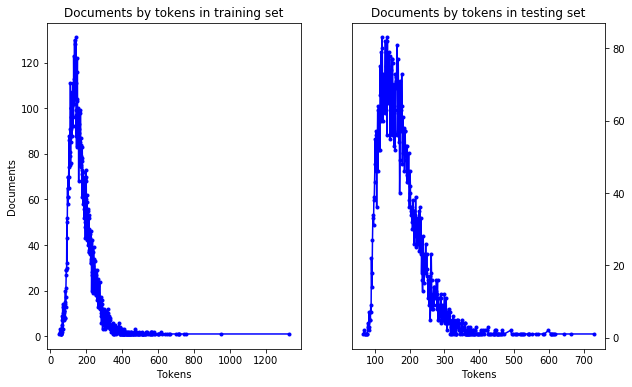

Length of 90.0% documents from training set is less then 300. Longer documents will be truncated.

Categories (labels): 40
Documents for training in category : maximum: 2800, minimum: 93, avegare: 415
Documents for testing  in category : maximum: 1501, minimum: 65, avegare: 276


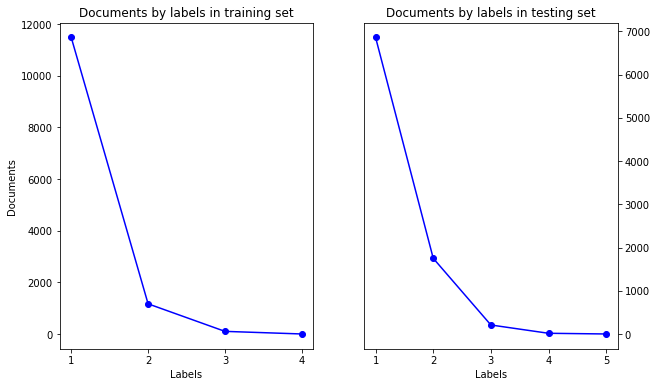

Distinct Label Set: 290
Proportion of Distinct Label Set: 0.0193
Label Cardinality: 1.1073
Label Density: 0.0277


In [3]:
print ("Dataset properties:")
maxDocLen = max(len(x.words) for x in trainAllDocs)
minDocLen = min(len(x.words) for x in trainAllDocs)
avrgDocLen = round(statistics.mean(len(x.words) for x in trainAllDocs), 2)
dls, qLabs = getLabelSets(trainAllDocs)

print ('Loaded %d documents: %d for training, %d for validation, %d for test' % (len(trainAllDocs) + len(testDocs), len(trainDocs), len(valDocs), len(testDocs)))
print ("Tokens in documents: maximum: %d, minimum: %d, average: %d"%(maxDocLen, minDocLen, avrgDocLen))
showDocsByLength(plt);

top_bound=0.9
maxLen = math.ceil(maxDocLen/100)*100 + 100
input_length_list=[]
for i in range(100, maxLen, 100):
    input_length_list.append(i)
input_length_dict={x:0 for x in input_length_list }
for i in range(len(trainAllDocs)):
    curLen = len(trainAllDocs[i].words)
    dictLen = maxLen
    for ln in input_length_dict:
        if curLen < ln:
            dicLen = ln
            break
    input_length_dict[dicLen] = input_length_dict[dicLen] + 1
input_length_dict_percentage={}
for k,v in input_length_dict.items():
    v=v/len(trainAllDocs)
    input_length_dict_percentage[k]=v
maxSeqLength=0
accumulate_percentage=0
for length,percentage in input_length_dict_percentage.items():
    accumulate_percentage+=percentage
    if accumulate_percentage>0.9:
        maxSeqLength=length
        break
print ("Length of %.1f%% documents from training set is less then %d. Longer documents will be truncated."%(top_bound*100, maxSeqLength))        

print()
print ("Categories (labels): %d"%(len(categories)))
print ("Documents for training in category : maximum: %d, minimum: %d, avegare: %d"%(max(fInCats1), min(fInCats1), round(statistics.mean(fInCats1), 2)))
print ("Documents for testing  in category : maximum: %d, minimum: %d, avegare: %d"%(max(fInCats2), min(fInCats2), round(statistics.mean(fInCats2), 2)))
showDocsByLabs(plt)
print ("Distinct Label Set: %d"%(dls))
print ("Proportion of Distinct Label Set: %.4f"%(dls/len(trainAllDocs)))
print ("Label Cardinality: %.4f"%(qLabs/len(trainAllDocs)))
print ("Label Density: %.4f"%(qLabs/len(trainAllDocs)/len(categories)))

#del trainAllDocs

#### Load W2V model

In [4]:
# Name of file with word vectors
modelName = 'model-2018-Nov-12-011941.vec'
#modelName = 'wiki_ar.vec'
ds = datetime.datetime.now()
w2v = gensim.models.KeyedVectors.load_word2vec_format(homePath + '/w2v/vectors/' + modelName)
de = datetime.datetime.now()
print ("Load W2V model (%s) in %s"%(modelName, showTime(ds, de))) 
print ("Continue")

Load W2V model (model-2018-Nov-12-011941.vec) in 3 min:3 sec
Continue


#### Prepare data for training and testing

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxWords = 130000
tokenizer = Tokenizer(num_words=maxWords)
allTexts = []
for i in range(len(trainAllDocs)):
    allTexts.append(" ".join(trainAllDocs[i].words))
tokenizer.fit_on_texts(allTexts)    
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

trainTexts = []
for i in range(len(trainDocs)):
    trainTexts.append(" ".join(trainDocs[i].words))
train_arrays = pad_sequences(tokenizer.texts_to_sequences(trainTexts), maxlen=maxSeqLength)

valTexts = []
for i in range(len(valDocs)):
    valTexts.append(" ".join(valDocs[i].words))
val_arrays = pad_sequences(tokenizer.texts_to_sequences(valTexts), maxlen=maxSeqLength)

testTexts = []
for i in range(len(testDocs)):
    testTexts.append(" ".join(testDocs[i].words))
test_arrays = pad_sequences(tokenizer.texts_to_sequences(testTexts), maxlen=maxSeqLength)

train_labels = numpy.concatenate([numpy.array(x.labels).reshape(1, len(categories)) for x in trainDocs])
val_labels = numpy.concatenate([numpy.array(x.labels).reshape(1, len(categories)) for x in valDocs])
test_labels = numpy.concatenate([numpy.array(x.labels).reshape(1, len(categories)) for x in testDocs])
print ("Train, validation and test data prepared")

embedding_matrix = numpy.zeros((maxWords, n_dim))
for word, i in word_index.items():
    if i < maxWords:
        try:
            embedding_vector = w2v[word] 
        except KeyError:
            continue
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print ("Embedding matrix built")            

Found 122070 unique tokens.
Train, validation and test data prepared
Embedding matrix built


#### Create, train and test the model

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.metrics import categorical_accuracy
import math

def getModel(n_dim):
    global batch_size
    model = Sequential()
    model.add(Embedding(maxWords, n_dim, input_length=maxSeqLength))
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    model.add(LSTM(maxSeqLength))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(categories), activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model    

model = getModel(n_dim)
# Quantity of epochs (loops) in which model is trained
eps = 10
verbose = 0
checkpoint = ModelCheckpoint(best_models_path + 'curModel%d.hdf5'%(modelId), monitor='val_acc', verbose=verbose, save_best_only=True, mode='auto')
print("Start training...", end='\r')

ds = datetime.datetime.now()
model.fit(train_arrays, train_labels, epochs=eps, validation_data=(val_arrays, val_labels), batch_size=batch_size, verbose=verbose, callbacks=[checkpoint], shuffle=False)
de = datetime.datetime.now()
print ("Model trained in %s"%(showTime(ds, de)))

# Evaluation of the final model
scores = model.evaluate(test_arrays, test_labels, verbose=1)
print("Final model accuracy: %.2f%%" % (scores[1]*100))

# Evaluation of the best model, saved in the training time
model1 = load_model(best_models_path + 'curModel%d.hdf5'%(modelId))
scores = model1.evaluate(test_arrays, test_labels, verbose=1)
print("Last saved model accuracy: %.2f%%" % (scores[1]*100))

Model trained in 2 h:10 min:20 sec
8836/8836 [==============================] - 267s 30ms/step
Final model accuracy: 98.49%
8836/8836 [==============================] - 270s 31ms/step
Last saved model accuracy: 98.53%


#### Save the model

In [7]:
# Set 'False' if you want to use the best model, saved in the training time
useFinalModel = False

modelPath = homePath + "/models/rtanews/models/"
modelName = "model%d-%s"%(modelId, datetime.datetime.now().strftime("%Y-%b-%d-%H%M%S"))

ds = datetime.datetime.now() 
if not useFinalModel:
    del model
    model = model1    
model.save(modelPath + modelName)
os.remove(best_models_path + 'curModel%d.hdf5'%(modelId))
de = datetime.datetime.now()
print ("Model %s saved in %s"%(modelName, showTime(ds,de)))

Model model4-2019-Feb-04-192447 saved in less than 1 sec


#### Calculate metrics

In [8]:
rankThreshold = 0.5

def rankIndicator(labels, predictions, index):
    global rankThreshold
    return (labels[index] == 1), (predictions[index] >= rankThreshold)
    
def getPrediction(entry):
    return entry[1]

ds = datetime.datetime.now()
res = model.predict(test_arrays)
de = datetime.datetime.now()
print ("Dataset containing %d documents predicted in %s\n"%(len(test_arrays), showTime(ds, de)))

# General results   
tp = 0
fp = 0
fn = 0
qTags = 0
qPreds = 0
for i in range(len(test_labels)):
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if predicted:
            qPreds += 1
            if actual:
                qTags += 1
                tp += 1
            else:
                fp += 1
        else:
            if actual:
                qTags += 1
                fn += 1
print ("Labels actual: %d, predicted: %d, correctly: %d, incorrectly: %d, not predicted: %d"%(qTags, qPreds, tp, fp, fn))

#Exact Match Ratio
wrongPreds = 0
for i in range(len(test_labels)):
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if (actual and not predicted) or (predicted and not actual):
            wrongPreds += 1
            break;
emr = (len(test_labels) - wrongPreds)/len(test_labels)           
print ("Exact Match Ratio:  %.2f%%" % ((len(test_labels) - wrongPreds)/len(test_labels) * 100))

#Accuracy
accuracy = 0.
for i in range(len(test_labels)):
    labels = sum(test_labels[i])
    tp = 0
    tfp = 0
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if actual and predicted:
            tp += 1
        if predicted and not actual:
            tfp += 1
    accuracy += tp / (labels + tfp)
modelAccuracy = accuracy / len(test_labels)
print ("Accuracy:  %.2f%%" % (accuracy / len(test_labels) * 100))  

#Precision
precision = 0.
for i in range(len(test_labels)):
    labels = sum(test_labels[i])
    tp = 0
    tfp = 0
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if actual and predicted:
            tp += 1
    precision += tp / labels
modelPrecision = precision / len(test_labels)
print ("Precision:  %.2f%%" % (precision / len(test_labels) * 100))  

#Recall
recall = 0.
for i in range(len(test_labels)):
    labels = sum(test_labels[i])
    tp = 0
    tfp = 0
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if actual and predicted:
            tp += 1
        if predicted:
            tfp += 1
    if tfp > 0:
        recall += tp / tfp
modelRecall = recall / len(test_labels)      
print ("Recall:  %.2f%%" % (recall / len(test_labels) * 100))  

#F1-Measure
f1 = 0.
for i in range(len(test_labels)):
    labels = sum(test_labels[i])
    tp = 0
    tfp = 0
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if actual and predicted:
            tp += 1
        if predicted:
            tfp += 1
    f1 += 2 * tp / (tfp + labels)
modelF1 = f1 / len(test_labels) 
print ("F1-Measure:  %.2f%%" % (f1 / len(test_labels) * 100))

#Hamming Loss
hl = 0.
for i in range(len(test_labels)):
    labels = sum(test_labels[i])
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if (actual and not predicted) or (predicted and not actual):
            hl += 1
modelHl = hl / (len(test_labels) * len(categories))           
print ("Hamming Loss:  %.2f%%" % (hl * 100 / (len(test_labels) * len(categories)))) 

#Macro-Averaged Precision
precision = 0
for i in range(len(categories)):
    tp = 0
    tact = 0
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i) 
        if not actual:
            continue
        tact += 1
        if predicted:
            tp += 1
    precision += tp / tact
modelMacroPrecision = precision / len(categories) 
print ("Macro-Averaged Precision:  %.2f%%" % (precision / len(categories) * 100))  

#Macro-Averaged Recall
recall = 0
for i in range(len(categories)):
    tp = 0
    tact = 0
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i)
        if predicted:
            tact += 1
            if actual:
                tp += 1
    recall += tp / tact
modelMacroRecall = recall / len(categories)
print ("Macro-Averaged Recall:  %.2f%%" % (recall / len(categories) * 100))  

#Macro-Averaged F1-Measure
f1 = 0
for i in range(len(categories)):
    tp = 0
    tact = 0
    labs = 0
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i)
        if actual:
            labs += 1
        if predicted:
            tact += 1
            if actual:
                tp += 1
    f1 += 2 * tp / (tact + labs)
modelMacroF1 = f1 / len(categories)
print ("Macro-Averaged F1-Measure:  %.2f%%" % (f1 / len(categories) * 100))  

#Micro-Averaged Precision
precision = 0
tp = 0
tact = 0
for i in range(len(categories)):
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i) 
        if not actual:
            continue
        tact += 1
        if predicted:
            tp += 1
precision += tp / tact
modelMicroPrecision = precision
print ("Micro-Averaged Precision:  %.2f%%" % (precision * 100))  

#Micro-Averaged Recall
recall = 0
tp = 0
tact = 0
for i in range(len(categories)):
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i)
        if predicted:
            tact += 1
            if actual:
                tp += 1
recall += tp / tact
modelMicroRecall = recall
print ("Micro-Averaged Recall:  %.2f%%" % (recall * 100))  

#Micro-Averaged F1-Measure
f1 = 0
tp = 0
tact = 0
labs = 0
for i in range(len(categories)):
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i)
        if actual:
            labs += 1
        if predicted:
            tact += 1
            if actual:
                tp += 1
f1 += 2 * tp / (tact + labs)
modelMicroF1 = f1
print ("Micro-Averaged F1-Measure:  %.2f%%" % (f1 * 100))  

#One error
o_err = 0
for i in range(len(test_labels)):
    list = [(0,0) for i in range(len(categories))]
    for j in range(len(categories)):
        list[j] = (test_labels[i][j], res[i][j])
    list.sort(key=getPrediction, reverse=True)
    if list[0][0] == 0:
        o_err += 1
print ("One Error: %.2f%%" % (o_err / len(test_labels) * 100))

#Coverage
stepsDown = 0
for i in range(len(test_labels)):
    bound = sum(test_labels[i]) - 1
    list = [(0,0,0) for i in range(len(categories))]
    for j in range(len(categories)):
        list[j] = (test_labels[i][j], res[i][j], j)
    list.sort(key=getPrediction, reverse=True)
    eSteps = 0
    for j in range(len(categories)):
        if test_labels[i][j] == 0:
            continue
        for k in range(len(list)):
            if list[k][2] == j:
                eSteps = max(eSteps, k)
    stepsDown += max(0, eSteps - bound)
print ("Coverage: %.2f" % (stepsDown / len(test_labels))) 

#Ranking Loss
rl = 0
for i in range(len(test_labels)):
    mult = sum(test_labels[i])
    list = [(0,0) for i in range(len(categories))]
    wrongOrder = 0
    for j in range(len(categories)):
        list[j] = (test_labels[i][j], res[i][j])
    list.sort(key=getPrediction, reverse=True)
    for j in range(len(list)):
        if list[j][0] == 1:
            mult -= 1
            if mult == 0:
                break
            continue
        wrongOrder += mult
    rl += wrongOrder / sum(test_labels[i])
print ("Ranking Loss: %.2f" % (rl / len(test_labels)))    

Dataset containing 8836 documents predicted in 4 min:20 sec

Labels actual: 11060, predicted: 8892, correctly: 7371, incorrectly: 1521, not predicted: 3689
Exact Match Ratio:  60.13%
Accuracy:  69.57%
Precision:  72.22%
Recall:  76.74%
F1-Measure:  72.84%
Hamming Loss:  1.47%
Macro-Averaged Precision:  61.10%
Macro-Averaged Recall:  81.71%
Macro-Averaged F1-Measure:  68.19%
Micro-Averaged Precision:  66.65%
Micro-Averaged Recall:  82.89%
Micro-Averaged F1-Measure:  73.89%
One Error: 17.95%
Coverage: 0.77
Ranking Loss: 0.60


#### Save model info

In [9]:
import pickle

modelInfoPath = homePath + '/models/rtanews/modelinfo/'
DocInfo = namedtuple('DocInfo', 'name actLabs predLabs dtype')
CategoryInfo = namedtuple('CategoryInfo', 'name actLabs predLabs wrongLabs notPredLabs qtyDocs qtyPredDocs precision recall f1')
ModelInfo = namedtuple('ModelInfo', 'name dataSet cats qtyDocs qtyPredDocs qtyPartDocs qtyWrongDocs actLabs predLabs wrongLabs notPredLabs emr accuracy precision recall f1 hl macroPrecision macroRecall macroF1 microPrecision microRecall microF1 catagories docs')

cNames = [''] * len(categories)
for k,v in categories.items():
    cNames[v] = k
mCorrDocs = 0
mPartDocs = 0
mWrongDocs = 0
cqTags = [0] * len(categories)
cqPreds = [0] * len(categories)
ctp = [0] * len(categories)
cfp = [0] * len(categories)
cfn = [0] * len(categories)
cDocs = [0] * len(categories)
cpDocs = [0] * len(categories)

docsInfo = []

for i in range(len(res)):
    qTags = 0
    qPreds = 0
    tp = 0
    fp = 0
    fn = 0
    dtype = 0
    actLabs = []
    predLabs = []
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if actual:
            cDocs[j] += 1
            actLabs.append(cNames[j])
        if predicted:
            qPreds += 1
            cqPreds[j] += 1
            predLabs.append(cNames[j])
            if actual:
                qTags += 1
                tp += 1
                cqTags[j] += 1
                ctp[j] += 1
                cpDocs[j] += 1
            else:
                fp += 1
                cfp[j] += 1
        else:
            if actual:
                qTags += 1
                fn += 1
                cqTags[j] += 1
                cfn[j] += 1
    if tp == qTags:
        if qPreds == tp:
            dtype = 2
        else:
            dtype = 3
        mCorrDocs += 1
    elif tp > 0:
        dtype = 1
        mPartDocs += 1
    else:
        mWrongDocs += 1
    docInfo = DocInfo(testDocs[i].name, actLabs, predLabs, dtype)
    docsInfo.append(docInfo)

categoriesInfo = []
for i in range(len(categories)):
    cPrec = ctp[i] / cqTags[i]
    cRec = ctp[i] / (ctp[i] + cfp[i])
    cF1 = 2 * ctp[i] / (ctp[i] + cfp[i] + cqTags[i])
    catInfo = CategoryInfo(cNames[i], cqTags[i], ctp[i], cfp[i], cfn[i], cDocs[i], cpDocs[i], cPrec, cRec, cF1)
    categoriesInfo.append(catInfo);

k = testRoot.rfind("/target")
sourceRoot = testRoot[:k] + "/source"
modelInfo = ModelInfo(modelName,sourceRoot,len(categories),len(res), mCorrDocs, mPartDocs, mWrongDocs, 
                      sum(cqTags),sum(ctp),sum(cfp),sum(cfn),emr,modelAccuracy,
                      modelPrecision,modelRecall,modelF1,modelHl,modelMacroPrecision,modelMacroRecall,
                      modelMacroF1,modelMicroPrecision,modelMicroRecall,modelMicroF1,categoriesInfo,docsInfo)
with open(modelInfoPath + modelName, 'wb') as f:
    pickle.dump(modelInfo, f)
print ("Model info saved.");
print ("Name: %s, data set: %s, documents: %d, categories: %d, actual labels: %d"%(modelInfo.name, modelInfo.dataSet, modelInfo.qtyDocs, modelInfo.cats, modelInfo.actLabs))

Model info saved.
Name: model4-2019-Feb-04-192447, data set: /home/user/MLClassificationData/test/rtanews/source, documents: 8836, categories: 40, actual labels: 11060
